In [1]:
import numpy as np
la = np.linalg

s1 = 'I like deep learning.'
s2 = 'I like NLP.'
s3 = 'I enjoy flying.'

words = ['I', 'like', 'enjoy', 'deep', 'learning', 'NLP', 'flying','.']
vocab = dict([(x, y) for (y, x) in enumerate(words)])
vocab

{'.': 7,
 'I': 0,
 'NLP': 5,
 'deep': 3,
 'enjoy': 2,
 'flying': 6,
 'learning': 4,
 'like': 1}

In [2]:
import re
def tokenizer(s):
    _WORD_SPLIT = re.compile("([.,!?\"':;)(])")
    sentences = re.split(_WORD_SPLIT,s )
    words = []
    for sentence in sentences:
        if sentence:
            words += sentence.strip().split()
    return words


In [3]:
# window based co-occurrence matrix
window = 2
X = np.zeros((len(words), len(words)))

for s in [s1, s3, s3]:
    toks = tokenizer(s)

    for i in range(len(toks)-1):
        word_i = vocab[toks[i]]
        for j in range(i+1, min(i+window,len(toks))):
            word_j = vocab[toks[j]]
            X[word_i][word_j] += 1
            X[word_j][word_i] += 1
                       
X

array([[0., 1., 2., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 2., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 1., 0., 2., 0.]])

In [4]:
U, s, Vh = la.svd(X, full_matrices = False)

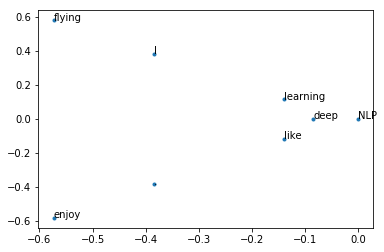

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(U[:,0], U[:,1], '.')

for i in range(len(words)):
    plt.text(U[i,0], U[i,1], words[i])

# The simple word2vec model

cost function J

$J(\theta) = \frac{1}{T}\sum^T_{t=1} \sum_{-c\leq j\leq c, j\neq 0} \log p(w_{t+j} \big|w_{t})$

with probabilities defined as: $p(w_O | w_I) = \frac{exp({v^{'}_{w_o}}^T v_{w_I})} {\sum_{w=1}^W exp({v^{'}_{w_o}}^T v_{w_I})}$

main idea: train binary logistic regressions for a	true pair (center word and word in its context window) and a couple	of random pairs	(the center	word with a	random	word)	

<img style="left;" src="img_files\skipgram1.png">


## Subsampling Frequent Words


## Sampling rate

* calculating a probability with which to keep a given word in the vocabulary.
$P(w_i) = (\sqrt{\frac{z(w_i)}{0.001}} + 1) \cdot\frac{0.001}{z(w_i)}$
* $w_i$ is the word, $z(w_i)$ is the fraction of the total words in the corpus that are that word.

## Negative Sampling

* having each training sample only modify a small percentage of the weights, rather than all of them.

* Essentially, the probability for selecting a word as a negative sample is related to its frequency, with more frequent words being more likely to be selected as negative samples.
$P(w_i) = \frac{f(w_i)^{3/4}}{\sum_{j=0}^n (f(w_j)*{3/4})}$




In [6]:
def get_train(s):
    
    X = []
    Y = []
    labels = []
    for l in s:
        toks = tokenizer(l)
        for i, tok in enumerate(toks):
            if i+1<len(toks):
                X.append(vocab[tok])
                Y.append(vocab[toks[i+1]])
                labels.append(1)
            if i-1>=0:
                X.append(vocab[tok])
                Y.append(vocab[toks[i-1]])
                labels.append(1)
           
            idxs = []
            
            # negative sampling
            while 1:
                idx = np.random.randint(len(vocab))
                if idx not in idxs and words[idx] not in toks:
                    idxs.append(idx)
                if len(idxs)>=2:
                    break
                        
            for idx in idxs:
                X.append(vocab[tok])
                Y.append(idx)
                labels.append(0)
         
    return np.array(X), np.array( Y), labels 
                
        
X, y, labels = get_train([s1,s2,s3])

In [7]:
from keras.layers import Input, Embedding, Reshape, merge, Dense, Dot
from keras.models import Sequential, Model

vocab_size = len(vocab)
vector_dim = 2

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# similarity = merge([target, context], mode='cos', dot_axes=0)
similarity = Dot(axes=0, normalize = True)([target, context])

# dot_product = merge([target, context], mode='dot', dot_axes=1)

dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

model.summary()

validation_model = Model(inputs=[input_target, input_context], outputs=similarity)
validation_model.summary()

/usr/lib/python3/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 1, 2)          16          input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 2, 1)          0           embedding[0][0]         

In [11]:
model.fit([X,y], labels, batch_size=4, epochs=1000,verbose =0, shuffle=True)

In [9]:
ids = np.random.choice(range(len(words)), 2)
    
sim = validation_model.predict_on_batch([np.array([ids[0]]), np.array([ids[1]])])

words[ids[0]], words[ids[1]], sim[0][0][0]

('I', 'learning', 0.0)

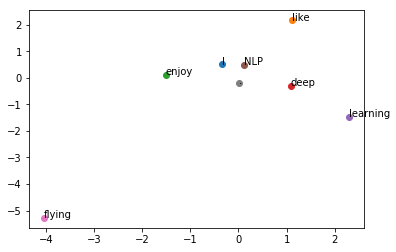

In [13]:
embedding_matrix = Model(inputs=input_target, outputs= target)

output = embedding_matrix.predict(np.array([range(len(words))]).reshape(-1))

for i, word in enumerate(words):
    pos = output[i]
    plt.plot(pos[0], pos[1], 'o')
    plt.text(pos[0], pos[1], word)

# continuous bag of	words (CBOW):	
Predict	center	word from sum of surrounding word vectors instead of predicting	surrounding	single words from center word as	in skipgram model

<img style="float: left;" src="img_files\cbow.png">


In [41]:
def get_train(s):
    
    word_index = []
    context = []
    label1 = []
    negatives = []
    label2 = []
    for l in s:
        toks = tokenizer(l)
        print(toks)
        for i, tok in enumerate(toks):
            
            if i+1<len(toks) & i-1>=0:
                word_index.append(vocab[tok])
               
                context.append([vocab[toks[i-1]],vocab[toks[i+1]]])
               
                
                label1.append(1)
            
            # negative sampling
                idxs=[]
                while 1:
                    idx = np.random.randint(len(vocab))
                    if idx not in idxs and words[idx] not in toks:
                        idxs.append(idx)
                    if len(idxs)>=2:
                        break

               
                negatives.append(vocab[tok])
                label2.append(0)
                    
         
    return np.array(word_index), np.array( context), np.array(label1), np.array(negatives), np.array(label2) 
                
        
word_index, context, label1, negatives, label2 = get_train([s1,s2,s3])

['I', 'like', 'deep', 'learning', '.']
['I', 'like', 'NLP', '.']
['I', 'enjoy', 'flying', '.']


In [42]:
context, word_index, negatives

(array([[7, 1],
        [7, 1],
        [7, 2]]), array([0, 0, 0]), array([0, 0, 0, 0, 0, 0]))

In [32]:
from keras.layers import Lambda, Multiply
import keras.backend as K

window = 1
neg_win = 2
EMBEDDING_DIM = 5

word_index = Input(shape=(1,))
context = Input(shape=(2*window,))

negative_samples = Input(shape=(neg_win,))


# Generate embedding matrix with all values between -1/2d, 1/2d
embedding = np.random.uniform(-1.0 / (2 * EMBEDDING_DIM),
                              1.0 / (2 * EMBEDDING_DIM),
                              (len(vocab), EMBEDDING_DIM))


# All inputs are processed through a common embedding layer
shared_embedding_layer = (Embedding(input_dim=(len(vocab)),
                                    output_dim=EMBEDDING_DIM,
                                    weights=[embedding]))



word_embedding = shared_embedding_layer(word_index)
context_embeddings = shared_embedding_layer(context)
negative_words_embedding = shared_embedding_layer(negative_samples)


# Now the context words are averaged to get the CBOW vector
cbow = Lambda(lambda x: K.mean(x, axis=1),
              output_shape=(EMBEDDING_DIM,))(context_embeddings)

# Context is multiplied (dot product) with current word and negative
# sampled words
word_context_product = Dot(axes = -1)([word_embedding, cbow])
negative_context_product = Dot(axes = -1)([negative_words_embedding, cbow])

# The dot products are outputted
model = Model(inputs=[word_index, context, negative_samples],
              outputs=[word_context_product, negative_context_product])

# Binary crossentropy is applied on the output
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_52 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_53 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
embedding_14 (Embedding)         multiple              40          input_52[0][0]                   
                                                                   input_53[0][0]                   
                                                                   input_54[0][0]                   
___________________________________________________________________________________________

In [35]:
model.fit([word_index, context, negatives], [label1, label2], batch_size=4, epochs=1000, verbose =0, shuffle=True)

ValueError: Error when checking input: expected input_54 to have shape (None, 2) but got array with shape (26, 1)